In [1]:
# Change this to match your folder name in Drive
#PUT PATH OF UNZIPPED DATASET FOLDER WHICH EXISTS IN DATASET FOLDER ITSELF
DATASET_ROOT = "/content/drive/MyDrive/dataset/dataset"
MODEL_PATH = f"{DATASET_ROOT}/unet_polygon_mask.pth"



In [2]:
import os
import json
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from tqdm import tqdm
import wandb


In [3]:
class PolygonColorDataset(Dataset):
    def __init__(self, root_dir, transform=None, augment=False):
        self.root_dir = root_dir
        self.inputs_dir = os.path.join(root_dir, "inputs")
        self.outputs_dir = os.path.join(root_dir, "outputs")
        self.transform = transform
        self.augment = augment

        # Load mapping file
        json_path = os.path.join(root_dir, "data.json")
        with open(json_path, "r") as f:
            self.mapping = json.load(f)

        # Fixed RGB color mapping (0-1 range for tensors)
        self.color_map = {
            "red": [1.0, 0.0, 0.0],
            "green": [0.0, 1.0, 0.0],
            "blue": [0.0, 0.0, 1.0],
            "yellow": [1.0, 1.0, 0.0],
            "cyan": [0.0, 1.0, 1.0],
            "magenta": [1.0, 0.0, 1.0],
            "purple": [0.5, 0.0, 0.5],
            "orange": [1.0, 0.5, 0.0]
        }

    def __len__(self):
        return len(self.mapping)

    def __getitem__(self, idx):
        item = self.mapping[idx]

        # Load polygon input and target output image
        input_img = Image.open(os.path.join(self.inputs_dir, item["input_polygon"])).convert("RGB").copy()
        target_img = Image.open(os.path.join(self.outputs_dir, item["output_image"])).convert("RGB").copy()

        # Create binary mask from input polygon
        mask_img = input_img.convert("L")  # grayscale
        mask_tensor = TF.to_tensor(mask_img)
        mask_tensor = torch.where(mask_tensor > 0.5, 1.0, 0.0)  # binary mask

        # Paired augmentations
        if self.augment:
            if random.random() > 0.5:
                input_img = TF.hflip(input_img)
                target_img = TF.hflip(target_img)
                mask_tensor = TF.hflip(mask_tensor)
            if random.random() > 0.5:
                input_img = TF.vflip(input_img)
                target_img = TF.vflip(target_img)
                mask_tensor = TF.vflip(mask_tensor)
            if random.random() > 0.5:
                angle = random.choice([90, 180, 270])
                input_img = TF.rotate(input_img, angle)
                target_img = TF.rotate(target_img, angle)
                mask_tensor = TF.rotate(mask_tensor, angle)

        # Transform input and output (e.g., Resize, Normalize)
        if self.transform:
            input_img = self.transform(input_img)
            target_img = self.transform(target_img)

        # Generate color RGB tensor
        color_name = item["colour"].lower()
        color_rgb = torch.tensor(self.color_map[color_name], dtype=torch.float32)  # shape: (3,)
        color_img = color_rgb.view(3, 1, 1).expand(3, input_img.shape[1], input_img.shape[2])  # shape: (3, H, W)

        # Combine original image with color image to make 6-channel input
        combined_input = torch.cat([input_img, color_img], dim=0)

        return combined_input, mask_tensor, target_img


In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=6, out_channels=3, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(2)

        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)

        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature * 2, feature))

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]
            if x.shape != skip_connection.shape:
                x = nn.functional.interpolate(x, size=skip_connection.shape[2:])
            x = self.ups[idx + 1](torch.cat((skip_connection, x), dim=1))

        return self.sigmoid(self.final_conv(x))


In [5]:
def train_model(model, train_loader, val_loader, device, epochs=50):
    wandb.init(project="unet")

    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3)

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for inputs, masks, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            inputs, masks, targets = inputs.to(device), masks.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            # Ensure mask has same shape as outputs
            if masks.ndim == 3:  # [B, H, W]
                masks = masks.unsqueeze(1)  # [B, 1, H, W]
            masks = masks.expand_as(outputs)  # [B, 3, H, W]

            # Masked L1 loss: only compute inside shape
            loss = torch.mean(torch.abs(outputs - targets) * masks)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        avg_train_loss = train_loss / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, masks, targets in val_loader:
                inputs, masks, targets = inputs.to(device), masks.to(device), targets.to(device)

                outputs = model(inputs)
                if masks.ndim == 3:
                    masks = masks.unsqueeze(1)
                masks = masks.expand_as(outputs)

                loss = torch.mean(torch.abs(outputs - targets) * masks)
                val_loss += loss.item() * inputs.size(0)

        avg_val_loss = val_loss / len(val_loader.dataset)
        scheduler.step(avg_val_loss)

        wandb.log({"Train Loss": avg_train_loss, "Validation Loss": avg_val_loss})
        print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}")

    wandb.finish()


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor()
])

train_dataset = PolygonColorDataset(f"{DATASET_ROOT}/training", transform=transform, augment=True)
val_dataset = PolygonColorDataset(f"{DATASET_ROOT}/validation", transform=transform, augment=False)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

model = UNet(in_channels=6, out_channels=3).to(device)
train_model(model, train_loader, val_loader, device, epochs=50)


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: lavkeshh17 (lavkeshh17-kk) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1/50: 100%|██████████| 7/7 [00:10<00:00,  1.52s/it]


Epoch 1: Train Loss=0.4702, Val Loss=0.4704


Epoch 2/50: 100%|██████████| 7/7 [00:01<00:00,  6.55it/s]


Epoch 2: Train Loss=0.4301, Val Loss=0.4577


Epoch 3/50: 100%|██████████| 7/7 [00:01<00:00,  6.83it/s]


Epoch 3: Train Loss=0.4002, Val Loss=0.4372


Epoch 4/50: 100%|██████████| 7/7 [00:01<00:00,  6.35it/s]


Epoch 4: Train Loss=0.3794, Val Loss=0.4109


Epoch 5/50: 100%|██████████| 7/7 [00:01<00:00,  5.73it/s]


Epoch 5: Train Loss=0.3678, Val Loss=0.3871


Epoch 6/50: 100%|██████████| 7/7 [00:01<00:00,  6.09it/s]


Epoch 6: Train Loss=0.3518, Val Loss=0.3673


Epoch 7/50: 100%|██████████| 7/7 [00:01<00:00,  6.98it/s]


Epoch 7: Train Loss=0.3460, Val Loss=0.3495


Epoch 8/50: 100%|██████████| 7/7 [00:00<00:00,  7.06it/s]


Epoch 8: Train Loss=0.3383, Val Loss=0.3403


Epoch 9/50: 100%|██████████| 7/7 [00:01<00:00,  5.60it/s]


Epoch 9: Train Loss=0.3312, Val Loss=0.3372


Epoch 10/50: 100%|██████████| 7/7 [00:01<00:00,  6.63it/s]


Epoch 10: Train Loss=0.3233, Val Loss=0.3342


Epoch 11/50: 100%|██████████| 7/7 [00:01<00:00,  6.91it/s]


Epoch 11: Train Loss=0.3249, Val Loss=0.3307


Epoch 12/50: 100%|██████████| 7/7 [00:01<00:00,  6.92it/s]


Epoch 12: Train Loss=0.3128, Val Loss=0.3215


Epoch 13/50: 100%|██████████| 7/7 [00:01<00:00,  6.92it/s]


Epoch 13: Train Loss=0.3079, Val Loss=0.3167


Epoch 14/50: 100%|██████████| 7/7 [00:01<00:00,  6.91it/s]


Epoch 14: Train Loss=0.3019, Val Loss=0.3119


Epoch 15/50: 100%|██████████| 7/7 [00:01<00:00,  6.69it/s]


Epoch 15: Train Loss=0.3026, Val Loss=0.3020


Epoch 16/50: 100%|██████████| 7/7 [00:01<00:00,  6.21it/s]


Epoch 16: Train Loss=0.2945, Val Loss=0.3030


Epoch 17/50: 100%|██████████| 7/7 [00:01<00:00,  5.84it/s]


Epoch 17: Train Loss=0.2891, Val Loss=0.3008


Epoch 18/50: 100%|██████████| 7/7 [00:01<00:00,  6.51it/s]


Epoch 18: Train Loss=0.2866, Val Loss=0.2904


Epoch 19/50: 100%|██████████| 7/7 [00:01<00:00,  6.87it/s]


Epoch 19: Train Loss=0.2837, Val Loss=0.2918


Epoch 20/50: 100%|██████████| 7/7 [00:01<00:00,  6.93it/s]


Epoch 20: Train Loss=0.2785, Val Loss=0.2870


Epoch 21/50: 100%|██████████| 7/7 [00:01<00:00,  6.89it/s]


Epoch 21: Train Loss=0.2809, Val Loss=0.2782


Epoch 22/50: 100%|██████████| 7/7 [00:01<00:00,  6.75it/s]


Epoch 22: Train Loss=0.2749, Val Loss=0.2774


Epoch 23/50: 100%|██████████| 7/7 [00:01<00:00,  6.90it/s]


Epoch 23: Train Loss=0.2696, Val Loss=0.2815


Epoch 24/50: 100%|██████████| 7/7 [00:01<00:00,  6.88it/s]


Epoch 24: Train Loss=0.2643, Val Loss=0.2719


Epoch 25/50: 100%|██████████| 7/7 [00:01<00:00,  6.94it/s]


Epoch 25: Train Loss=0.2631, Val Loss=0.2693


Epoch 26/50: 100%|██████████| 7/7 [00:01<00:00,  6.82it/s]


Epoch 26: Train Loss=0.2648, Val Loss=0.2655


Epoch 27/50: 100%|██████████| 7/7 [00:01<00:00,  6.01it/s]


Epoch 27: Train Loss=0.2625, Val Loss=0.3459


Epoch 28/50: 100%|██████████| 7/7 [00:01<00:00,  6.13it/s]


Epoch 28: Train Loss=0.2570, Val Loss=0.2658


Epoch 29/50: 100%|██████████| 7/7 [00:01<00:00,  5.96it/s]


Epoch 29: Train Loss=0.2554, Val Loss=0.2609


Epoch 30/50: 100%|██████████| 7/7 [00:01<00:00,  6.92it/s]


Epoch 30: Train Loss=0.2503, Val Loss=0.2495


Epoch 31/50: 100%|██████████| 7/7 [00:01<00:00,  6.82it/s]


Epoch 31: Train Loss=0.2454, Val Loss=0.2483


Epoch 32/50: 100%|██████████| 7/7 [00:01<00:00,  6.82it/s]


Epoch 32: Train Loss=0.2453, Val Loss=0.2485


Epoch 33/50: 100%|██████████| 7/7 [00:01<00:00,  6.92it/s]


Epoch 33: Train Loss=0.2379, Val Loss=0.2469


Epoch 34/50: 100%|██████████| 7/7 [00:01<00:00,  6.86it/s]


Epoch 34: Train Loss=0.2432, Val Loss=0.2461


Epoch 35/50: 100%|██████████| 7/7 [00:01<00:00,  6.84it/s]


Epoch 35: Train Loss=0.2360, Val Loss=0.2372


Epoch 36/50: 100%|██████████| 7/7 [00:01<00:00,  6.85it/s]


Epoch 36: Train Loss=0.2360, Val Loss=0.2430


Epoch 37/50: 100%|██████████| 7/7 [00:01<00:00,  6.81it/s]


Epoch 37: Train Loss=0.2255, Val Loss=0.2354


Epoch 38/50: 100%|██████████| 7/7 [00:01<00:00,  6.54it/s]


Epoch 38: Train Loss=0.2249, Val Loss=0.2398


Epoch 39/50: 100%|██████████| 7/7 [00:01<00:00,  6.08it/s]


Epoch 39: Train Loss=0.2235, Val Loss=0.2296


Epoch 40/50: 100%|██████████| 7/7 [00:01<00:00,  6.09it/s]


Epoch 40: Train Loss=0.2199, Val Loss=0.2180


Epoch 41/50: 100%|██████████| 7/7 [00:01<00:00,  5.81it/s]


Epoch 41: Train Loss=0.2179, Val Loss=0.2179


Epoch 42/50: 100%|██████████| 7/7 [00:01<00:00,  6.87it/s]


Epoch 42: Train Loss=0.2169, Val Loss=0.2209


Epoch 43/50: 100%|██████████| 7/7 [00:01<00:00,  6.67it/s]


Epoch 43: Train Loss=0.2152, Val Loss=0.2220


Epoch 44/50: 100%|██████████| 7/7 [00:01<00:00,  6.82it/s]


Epoch 44: Train Loss=0.2103, Val Loss=0.2143


Epoch 45/50: 100%|██████████| 7/7 [00:01<00:00,  6.79it/s]


Epoch 45: Train Loss=0.2050, Val Loss=0.2150


Epoch 46/50: 100%|██████████| 7/7 [00:01<00:00,  6.78it/s]


Epoch 46: Train Loss=0.2067, Val Loss=0.2190


Epoch 47/50: 100%|██████████| 7/7 [00:01<00:00,  6.85it/s]


Epoch 47: Train Loss=0.2029, Val Loss=0.2166


Epoch 48/50: 100%|██████████| 7/7 [00:01<00:00,  6.72it/s]


Epoch 48: Train Loss=0.1983, Val Loss=0.2040


Epoch 49/50: 100%|██████████| 7/7 [00:01<00:00,  6.77it/s]


Epoch 49: Train Loss=0.1947, Val Loss=0.2016


Epoch 50/50: 100%|██████████| 7/7 [00:01<00:00,  6.08it/s]


Epoch 50: Train Loss=0.1918, Val Loss=0.2042


Train Loss,█▇▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
Validation Loss,██▇▆▆▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▅▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Train Loss,0.1918
Validation Loss,0.20419


In [7]:

# 1. Start a W&B run
wandb.init(project="unet", name="final_model_upload")

# 2. Save model locally
MODEL_PATH = "unet_polygon_color.pth"
torch.save(model.state_dict(), MODEL_PATH)

# 3. Create and log artifact
artifact = wandb.Artifact("unet_polygon_color", type="model")
artifact.add_file(MODEL_PATH)
wandb.log_artifact(artifact)

# 4. End run
wandb.finish()


In [8]:
from skimage.metrics import structural_similarity as ssim
import torch.nn.functional as F

def evaluate_metrics(model, loader, device):
    model.eval()
    mse_total, mae_total, ssim_total = 0, 0, 0
    count = 0

    with torch.no_grad():
        for inputs, _, targets in loader:  #
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            mse_total += F.mse_loss(outputs, targets, reduction='sum').item()
            mae_total += F.l1_loss(outputs, targets, reduction='sum').item()

            # Convert for SSIM
            outputs_np = outputs.cpu().numpy().transpose(0,2,3,1)
            targets_np = targets.cpu().numpy().transpose(0,2,3,1)
            for i in range(outputs_np.shape[0]):
                ssim_total += ssim(outputs_np[i], targets_np[i], channel_axis=2, data_range=1.0)
            count += outputs.size(0)

    mse_avg = mse_total / count
    mae_avg = mae_total / count
    ssim_avg = ssim_total / count
    return mse_avg, mae_avg, ssim_avg


In [9]:
mse, mae, ssim_score = evaluate_metrics(model, val_loader, device)
print(f"Validation MSE: {mse:.4f}")
print(f"Validation MAE: {mae:.4f}")
print(f"Validation SSIM: {ssim_score:.4f}")


Validation MSE: 2450.0375
Validation MAE: 10404.5406
Validation SSIM: 0.8329


In [10]:
import matplotlib.pyplot as plt

def show_predictions(model, loader, device, num_images=3):
    model.eval()
    inputs, _, targets = next(iter(loader))
    inputs, targets = inputs.to(device), targets.to(device)

    with torch.no_grad():
        outputs = model(inputs)

    for i in range(min(num_images, inputs.size(0))):
        pred_img = outputs[i].cpu().permute(1, 2, 0).numpy()
        target_img = targets[i].cpu().permute(1, 2, 0).numpy()
        input_polygon = inputs[i, :3].cpu().permute(1, 2, 0).numpy()

        fig, axs = plt.subplots(1, 3, figsize=(10, 4))
        axs[0].imshow(input_polygon)
        axs[0].set_title("Polygon Input")

        axs[1].imshow(target_img)
        axs[1].set_title("Ground Truth")

        axs[2].imshow(pred_img)
        axs[2].set_title("Model Prediction")

        for ax in axs:
            ax.axis("off")
        plt.show()


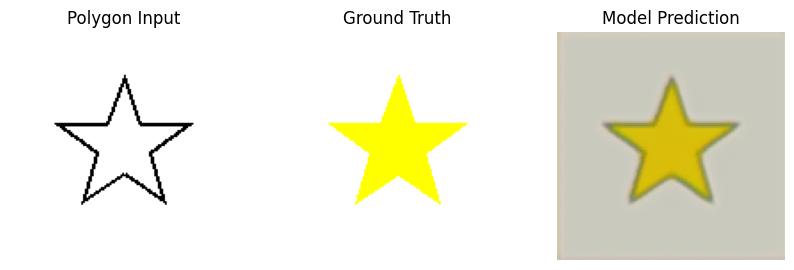

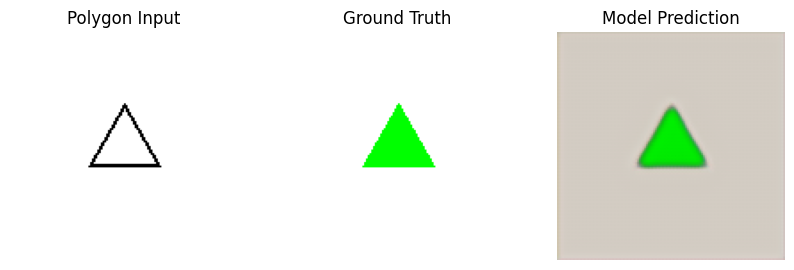

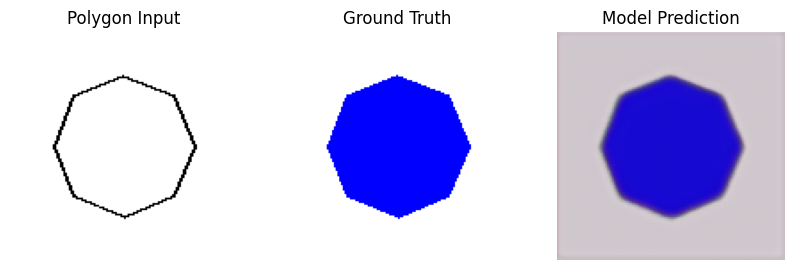

In [11]:
show_predictions(model, val_loader, device, num_images=3)
